Created by: Ethan Nanavtai
Last Edited: 1/9/2025
Known Bugs: CVXPY will not admit var_max values below 1. For values in that range, be sure to use the primal dual function.

NOTES: 

variance for the main experiment and delta_hat experiments is true sample portfolio variance.


variance for other experiments and plots is a proxy as portfolio variance per month. This was done for a continuous plot, but is meaningfully distrinct from sample portfolio variance

Each experiment can be run distinct from the others, but before beginning, load the libraries, run Data Cleaning, and run Helpful Functions.

You can change which stocks are included in the Data Cleaning tab

In [129]:
import numpy as np
import cvxpy as cp
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import time

# Data Cleaning

Capture the raw df

In [133]:
# a list of all the tickers in s&p 500 as of 12/6/2024
tickers = []
with open("tickers_etal.txt") as file:
    for line in file:
        tickers.append(line.split()[1])

    
df = yf.download(tickers,'2004-01-01','2024-01-01',interval='1mo') # pull data on all the tickers for the last 20 years
df = df['Adj Close'] # keep only the eod prices (for an absolute reference)
df = df.dropna(axis=1) # only keep tickers with full data

[*********************100%***********************]  503 of 503 completed

6 Failed downloads:
['SW', 'SOLV', 'AMTM', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1mo 2004-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1072933200, endDate = 1704085200")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1mo 2004-01-01 -> 2024-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [134]:
df

Ticker,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WRB,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,22.209604,0.339829,11.048244,4.632988,16.780817,19.119045,29.837465,9.632354,20.833906,12.804041,...,3.587003,7.214650,61.089603,11.191308,15.993270,7.850174,20.502726,8.382759,66.579315,43.066666
2004-02-01,20.600826,0.360315,11.037285,4.480845,16.376717,18.600964,31.115753,10.579598,20.687700,14.334146,...,3.879478,7.517904,63.318550,11.957959,19.681519,7.918160,21.196377,9.154044,65.830872,47.653332
2004-03-01,19.058319,0.407313,10.598886,4.448092,17.581930,19.624641,29.961435,10.423011,20.468403,15.709745,...,3.714613,7.623903,61.419834,12.003782,18.955795,8.072262,21.034660,9.391361,64.212074,46.246666
2004-04-01,16.274591,0.388333,11.351893,4.243120,16.851715,20.729950,26.585213,10.849323,21.420052,16.717510,...,3.778782,7.909290,60.259930,10.849217,21.625847,7.662749,21.520187,9.589124,69.494888,48.860001
2004-05-01,15.485268,0.422677,11.430899,4.063506,17.447229,22.293438,30.672861,10.274731,21.723196,17.889881,...,3.886081,7.790199,59.181202,11.152802,20.938021,7.781834,21.874222,9.270227,74.281647,53.919998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,119.791183,186.456345,100.331299,73.086060,317.331482,559.340027,177.067810,75.663605,246.406021,221.940002,...,39.527203,405.688141,202.692490,31.423258,99.724655,54.068745,105.681641,125.669533,117.613312,275.010010
2023-09-01,110.638901,170.151169,94.432320,75.796120,301.002777,509.899994,170.551239,72.344795,232.828079,206.910004,...,40.568741,374.092529,204.849228,29.587763,91.141502,54.153923,112.671181,121.925407,110.800583,236.529999
2023-10-01,102.278145,169.713898,92.189735,82.423882,291.182068,532.059998,153.980103,68.651764,212.245346,197.630005,...,43.487217,317.342072,232.171051,27.686661,86.575043,56.600388,101.430893,117.943848,103.313232,209.429993


### select which stocks are included

In [136]:
returns = df.diff().dropna()
returns = returns.iloc[:,0:50]

In [137]:
returns

Ticker,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,BAC,BALL,BAX,BBY,BDX,BEN,BG,BIIB,BK,BKNG
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,-1.608778,0.020487,-0.010960,-0.152143,-0.404100,-0.518082,1.278288,0.947245,-0.146206,1.530106,...,0.141323,0.205477,-0.011024,1.155935,2.496981,-0.223764,3.183857,12.470001,0.926508,3.855814
2004-03-01,-1.542507,0.046997,-0.438398,-0.032753,1.205214,1.023678,-1.154318,-0.156588,-0.219297,1.375599,...,-0.288790,0.346130,0.650198,-0.597670,-0.118237,-0.144473,0.847281,0.149998,-0.974672,3.905375
2004-04-01,-2.783728,-0.018980,0.753007,-0.204972,-0.730215,1.105309,-3.376223,0.426312,0.951649,1.007765,...,0.091597,-0.183310,0.279176,0.988304,1.548141,-0.135005,-2.087240,3.400002,-1.533504,-2.666357
2004-05-01,-0.789324,0.034344,0.079005,-0.179614,0.595514,1.563488,4.087648,-0.574593,0.303144,1.172371,...,0.819025,0.237885,-0.077140,-0.543083,-0.160465,-0.802903,0.059265,3.150002,0.736994,1.913038
2004-06-01,2.157084,0.067484,0.714447,0.150031,2.034683,0.934097,-1.255585,0.138834,-1.246780,3.467226,...,0.462257,0.401963,1.127743,-0.790564,1.032570,-0.035288,1.265533,1.099998,-0.385983,0.723583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,-0.692604,-8.515442,-7.701447,-0.789246,8.393707,13.170044,-17.289886,-5.400459,7.113174,9.949997,...,-3.195026,-4.156990,-4.433380,-6.168060,0.810028,-2.310280,5.424187,-2.830017,-0.069645,133.050293
2023-09-01,-9.152283,-16.305176,-5.898979,2.710060,-16.328705,-49.440033,-6.516571,-3.318810,-13.577942,-15.029999,...,-1.018793,-4.398502,-2.487114,-6.523178,-20.417267,-1.996078,-5.204414,-10.349976,-2.135616,-20.894775
2023-10-01,-8.360756,-0.437271,-2.242584,6.627762,-9.820709,22.160004,-16.571136,-3.693031,-20.582733,-9.279999,...,-1.006159,-1.603981,-5.119894,-1.672714,-4.766998,-1.390575,-2.192329,-19.470016,-0.144299,-291.802734


In [138]:
NUM_STOCKS = returns.shape[1]
NUM_PERIODS = returns.shape[0]
NUM_TRAINING_TIME_PERIODS = 60

N = NUM_STOCKS
T = NUM_TRAINING_TIME_PERIODS

# Experiments

### Helpful Functions

In [12]:
# Sigma: covariance matrix
# mu: investment means
# desired_var: sigma^2_max ie max variance for portfolio
def inbuilt_constrained_solver(Sigma, mu, desired_var):
    # make sure the problem is feasible
    required_var = np.min(np.diag(Sigma)) + 1e-4 # add 1 for Slater's condition
    var_max = max(desired_var,required_var)
    if (desired_var != var_max):
        print("var_max SET TOO LOW. CHOOSE A FEASIBLE VALUE")

    # solve the problem
    x = cp.Variable(N)
    constraints = [x >= 0, x.T @ np.ones(N) == 1 , cp.quad_form(x,Sigma) <= var_max]
    objective = cp.Maximize(x.T @ mu)
    problem = cp.Problem(objective, constraints)
    result = problem.solve()
    optimal_value = problem.value
    optimal_allocation = x.value

    return [optimal_value, optimal_allocation]

# returns the variance of your allocation
# next_month_returns: the actual returns of the stock
# stock_allocation: the computed allocation for your portfolio over the stocks
def returns_variance(next_month_returns, stock_allocation):
    total_return = next_month_returns.T @ stock_allocation
    individual_returns = next_month_returns.T * stock_allocation
    average_return = total_return / N
    variance = np.sum(np.square(average_return - individual_returns))
    return variance


# S is the sample covariance matrix
def get_structured_mat_F(S):
    # Compute the structured matrix F
    R = np.divide(S, np.outer(np.sqrt(np.diag(S)), np.sqrt(np.diag(S))))
    r_bar = (np.ones(N).T @ R @ np.ones(N) - np.trace(R)) / ((N-1)*N)
    F = r_bar * np.outer(np.sqrt(np.diag(S)), np.sqrt(np.diag(S))) # at this point the diagonals still need to be set
    np.fill_diagonal(F,np.diag(F) / r_bar) # set the diagonal elements
    return F

In [13]:
# returns the solution to (9) (predicted return, optimal allocation)
# NOTE: sigma_max is actually var_max. Ie input your varmax and it will work fine
def my_primal_dual(Sigma,mu,desired_var):

    # Make Sure the Problem is Feasible
    required_var = np.min(np.diag(Sigma)) + 1e-4 # add 1 for Slater's condition
    sigma_max = max(desired_var,required_var)
    if (desired_var != desired_var):
        print("var_max SET TOO LOW. CHOOSE A FEASIBLE VALUE")
        
    # Helpful Functions in the problem
    def objective(x):
        return -1*mu.T @ x # negative because we are maximizing XD
    
    def neg_f(x):
        return -1 * np.vstack([(x.T @ Sigma @ x - sigma_max).reshape(1, 1), -1*x.reshape(-1, 1)]).ravel()
        
    # Set Variables
    x_feasible = np.zeros(N) # find a feasible starting x
    x_feasible[np.argmin(np.diag(S))] = 1    
    x = x_feasible 
    
    l = np.ones(N+1)
    v = 1
    A = np.ones(N).T
    b = np.ones(1)
    m = N+1
    
    
    lamda = l #yes I know it's spelled wrong
    mu_IPM = 10
    beta = .7
    alpha = .01
    epsilon_feas = 1e-9
    epsilon = 1e-7
    res_dual = 10 # anything big is fine
    res_primal = 10 # anything big is fine
    eta = 10 # anything big is fine

    while((res_dual > epsilon_feas) or (res_primal > epsilon_feas) or (eta > epsilon)):
        # Find the Next Direction ~~~~~~~~~~~~~~~~~
        
        # Derived Matrices (problem specific!)
        B = 2* l[0] * Sigma # first block of KKT
        Df = np.block([[(2*Sigma@x).T],[-1*np.eye(N)]]) #test this
        f = np.vstack([(x.T @ Sigma @ x - sigma_max).reshape(1, 1), -1*x.reshape(-1, 1)]).ravel()
        grad_f = -1*mu

        # Derived Variables (problem specific!)
        eta = (-1 * f).T @ lamda
        t = mu_IPM * m / eta

        # Build the KKT matrix
        C = np.diag(-1*f) # 2,2 block of KKT
        KKT_matrix = np.block([
            [B, Df.T, A.T.reshape(-1, 1)],
            [-np.diag(lamda) @ Df, C, np.zeros((N+1, 1))],
            [A.reshape(1, -1), np.zeros((1, N+1)), np.array([[0]])]
        ])

        # Determine the Residuals
        r_dual = (grad_f + Df.T @ lamda + A.T * v).reshape(-1, 1)
        r_cent = (np.diag(lamda)@(-1*f) - 1/t).reshape(-1, 1)
        r_pri = A@x - b

        # Solve For Next Direction
        deltas = np.linalg.solve(KKT_matrix, -1 * np.vstack([r_dual, r_cent, r_pri]).ravel())
        del_x = deltas[0:N]
        del_l = deltas[N:2*N+1]
        del_v = deltas[2*N+1]


        # Line Search ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        s = 1
        
        # Lambda positive constraint satisfied
        while np.any(lamda + del_l * s <= 0):
            s *= beta
            
        # Inequality constraints satisfied
        while np.any(-1*neg_f(x+del_x*s) > 0):
            s *= beta

        # Line Search for Improvement
        og_resid = np.linalg.norm(np.vstack([r_dual, r_cent, r_pri]).ravel(),2)
        new_resid = og_resid
        while (new_resid > (1-alpha*s) * og_resid):
            # update s
            s *= beta
        
            # update new_resid
            x_new = x + s*del_x
            l_new = l + s*del_l
            v_new = v + s*del_v
            
            Df_new = np.block([[(2*Sigma@x_new).T],[-1*np.eye(N)]]) 
            f_new = np.vstack([(x_new.T @ Sigma @ x_new - sigma_max).reshape(1, 1), -1*x_new.reshape(-1, 1)]).ravel()
            grad_f_new = -1*mu
            
            r_dual_new = (grad_f_new + Df_new.T @ l_new + A.T * v_new).reshape(-1, 1)
            r_cent_new = (np.diag(l_new)@(-1*f_new) - 1/t).reshape(-1, 1)
            r_pri_new = A@x_new - b
            
            new_resid = np.linalg.norm(np.vstack([r_dual_new, r_cent_new, r_pri_new]).ravel(),2)

        # Take a Step and Update ~~~~~~~~~~~~~~~~~~

        # Update Variables for the Next Iteration
        x += s*del_x
        l += s*del_l
        v += s*del_v
        lamda = l

        res_dual = np.linalg.norm(r_dual_new,2)
        res_primal = np.linalg.norm(r_pri_new,2)
        eta = -1*f_new.T@l
        # print(round(x.T@mu,2),round(sigma_max - neg_f(x)[0],2))

    return [x.T@mu, x] # value, x

### Main Expt: compare estimators across time windows

In [23]:
# print(returns.iloc[55:130 + T,:].T)

In [26]:
print(returns.shape)

(239, 50)


NOTE: In the paper var_max is set to 4 to generate the table. This is so that the numbers were all very similar, to allow for easier comparinsons

In [124]:
portfolio_returns = []
shrunk_portfolio_returns = []
market_returns = []
t_start = time.time()

for start_pd in range(55, 131):
    if start_pd % 10 == 0: print(start_pd)
    sample_returns = returns.iloc[start_pd:start_pd + T,:].T
    next_month_returns = returns.iloc[start_pd + T,:]

    sample_covariance_matrix = np.cov(sample_returns) #sample
    S = sample_covariance_matrix
    
    F = get_structured_mat_F(sample_covariance_matrix) #shrunk
    delta_star_hat = .6
    S_shrunk = delta_star_hat * F + (1-delta_star_hat)*S
    
    
    sample_mu = sample_returns.mean(axis=1).to_numpy()
    expected_return = sample_mu

    # a good value seems to be 8 for var_max
    predicted_val, sample_cov_allocation = my_primal_dual(S,expected_return,8) #inbuilt_constrained_solver(S,expected_return,8) #sampple

    shrunk_predicted_val, shrunk_cov_allocation = my_primal_dual(S_shrunk,expected_return,8) #inbuilt_constrained_solver(S_shrunk,expected_return,8) #shrunk
    
    portfolio_return = next_month_returns.T @ sample_cov_allocation #sample
    shrunk_portfolio_return = next_month_returns.T @ shrunk_cov_allocation #shrunk

    portfolio_returns.append(portfolio_return) #sample
    shrunk_portfolio_returns.append(shrunk_portfolio_return) #shrunk
    market_returns.append(np.mean(next_month_returns))


t_end = time.time()
print("my code time", t_end-t_start)

60
70
80
90
100
110
120
130
my code time 11.512972831726074


my code time 10.25985860824585
cvxpy time 11.44788122177124

cvxpy FAILS at sigma_max = 1. Mine does not

In [126]:
print("average sample returns", np.mean(portfolio_returns)) #sample
print("average shrunk returns", np.mean(shrunk_portfolio_returns)) #shrunk
print("average market return", np.mean(market_returns))
print("sample variance", np.var(portfolio_returns))# np.mean(np.sqrt(portfolio_variances)))
print("shrunk variances", np.var(shrunk_portfolio_returns)) # np.mean(np.sqrt(shrunk_portfolio_variances)))
print("market_variance", np.var(market_returns))

average sample returns 2.454206656799564
average shrunk returns 2.2000072087555664
average market return 1.4244750884959574
sample variance 34.916315776844456
shrunk variances 34.49521030557285
market_variance 19.67784934841715


Text(0.5, 0, 'Plot generated with: start_pd from 55 to 131. T=60, N from 0:50, var_max=8')

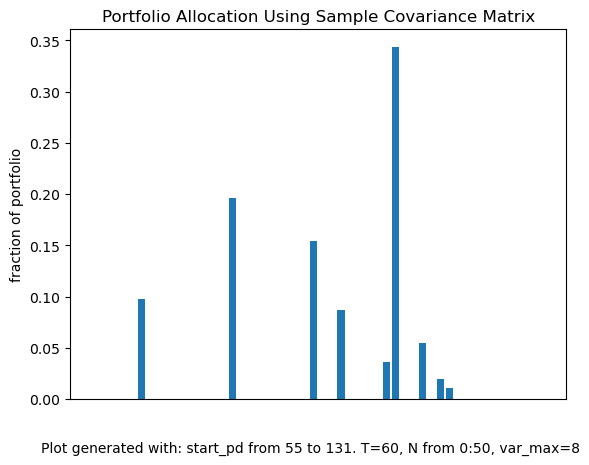

In [96]:
plt.bar(np.arange(len(sample_cov_allocation)),sample_cov_allocation)
plt.ylabel("fraction of portfolio")
plt.xticks([])
plt.title("Portfolio Allocation Using Sample Covariance Matrix")
plt.figtext(0.5, 0, "Plot generated with: start_pd from 55 to 131. T=60, N from 0:50, var_max=8", ha="center", fontsize=10)

Text(0.5, 0, 'Plot generated with: start_pd from 55 to 131. T=60, N from 0:50, var_max=8, delta=.6')

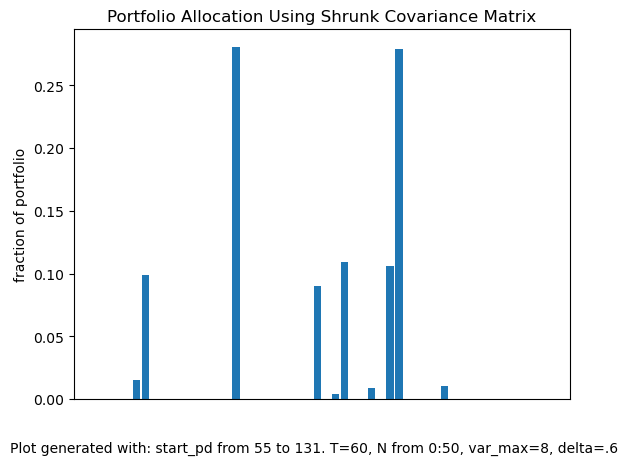

In [98]:
plt.bar(np.arange(len(shrunk_cov_allocation)),shrunk_cov_allocation)
plt.ylabel("fraction of portfolio")
plt.xticks([])
plt.title("Portfolio Allocation Using Shrunk Covariance Matrix")
plt.figtext(0.5, 0, "Plot generated with: start_pd from 55 to 131. T=60, N from 0:50, var_max=8, delta=.6", ha="center", fontsize=10)

### Effect of delta_star_hat on M and V

In [102]:
returns_per_delta = []
variances_per_delta = []
time_start = time.time()
for delta_star_hat in np.arange(0,1.01,.05):
    print(delta_star_hat)
    shrunk_portfolio_returns = []
    # shrunk_portfolio_variances = []
    for start_pd in range(55, 131):
        sample_returns = returns.iloc[start_pd:start_pd + T,:].T
        next_month_returns = returns.iloc[start_pd + T,:]
    
        sample_covariance_matrix = np.cov(sample_returns) #sample
        S = sample_covariance_matrix
        
        F = get_structured_mat_F(sample_covariance_matrix) #shrunk
        S_shrunk = delta_star_hat * F + (1-delta_star_hat)*S
        
        
        sample_mu = sample_returns.mean(axis=1).to_numpy()
        expected_return = sample_mu
    
        # a good value seems to be 8 for var_max
        shrunk_predicted_val, shrunk_cov_allocation = my_primal_dual(S_shrunk,expected_return,8) #inbuilt_constrained_solver(S_shrunk,expected_return,8) #shrunk
    
        shrunk_portfolio_return = next_month_returns.T @ shrunk_cov_allocation #shrunk
    
        shrunk_portfolio_returns.append(shrunk_portfolio_return) #shrunk
    
    returns_per_delta.append(np.mean(shrunk_portfolio_returns))
    variances_per_delta.append(np.var(shrunk_portfolio_returns))

time_end = time.time()
print("my algorithm's total time: ", time_end-time_start)

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0
my algorithm's total time:  150.42546701431274


my algorithm's total time:  124.02032470703125
CVXPY's total time:  109.92392802238464

Text(0.5, -0.02, 'Plot generated with: start_pd from 55 to 131. T=60, N from 0:50, var_max=8')

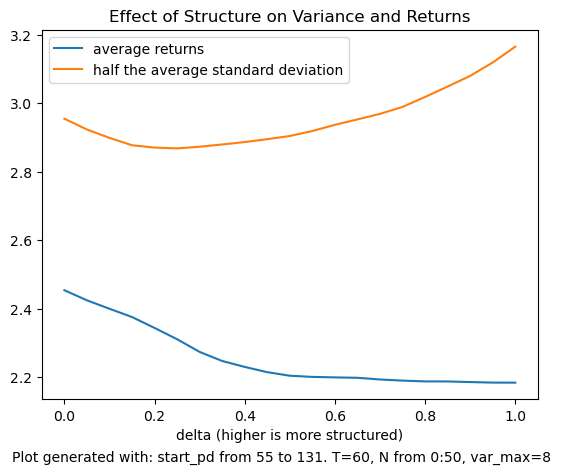

In [104]:
plt.plot(np.arange(0,1.01,.05),returns_per_delta, label="average returns")
plt.plot(np.arange(0,1.01,.05),np.sqrt(variances_per_delta)/2, label="half the average standard deviation")
plt.xlabel("delta (higher is more structured)")
plt.legend()
plt.title("Effect of Structure on Variance and Returns")
plt.figtext(0.5, -.02, "Plot generated with: start_pd from 55 to 131. T=60, N from 0:50, var_max=8", ha="center", fontsize=10)

### Mean and Variance over time

In [84]:
portfolio_returns = []
portfolio_variances = []
shrunk_portfolio_returns = []
shrunk_portfolio_variances = []

for start_pd in range(55, 131):
    if start_pd%10 ==0: print(start_pd)
    sample_returns = returns.iloc[start_pd:start_pd + T,:].T
    next_month_returns = returns.iloc[start_pd + T,:]

    sample_covariance_matrix = np.cov(sample_returns) #sample
    S = sample_covariance_matrix
    
    F = get_structured_mat_F(sample_covariance_matrix) #shrunk
    delta_star_hat = .6
    S_shrunk = delta_star_hat * F + (1-delta_star_hat)*S
    
    
    sample_mu = sample_returns.mean(axis=1).to_numpy()
    expected_return = sample_mu

    # a good value seems to be 8 for var_max
    predicted_val, sample_cov_allocation = my_primal_dual(S,expected_return,8) #inbuilt_constrained_solver(S,expected_return,8) #sampple

    shrunk_predicted_val, shrunk_cov_allocation = my_primal_dual(S_shrunk,expected_return,8) #inbuilt_constrained_solver(S_shrunk,expected_return,8) #shrunk

    
    portfolio_return = next_month_returns.T @ sample_cov_allocation #sample
    portfolio_variance = returns_variance(next_month_returns, sample_cov_allocation)
    shrunk_portfolio_return = next_month_returns.T @ shrunk_cov_allocation #shrunk
    shrunk_portfolio_variance = returns_variance(next_month_returns, shrunk_cov_allocation)

    portfolio_returns.append(portfolio_return) #sample
    portfolio_variances.append(portfolio_variance)
    shrunk_portfolio_returns.append(shrunk_portfolio_return) #shrunk
    shrunk_portfolio_variances.append(shrunk_portfolio_variance)

60
70
80
90
100
110
120
130


Text(0.5, -0.1, 'start_pd from 55 to 131. T=60, N from 0:50, var_max=8')

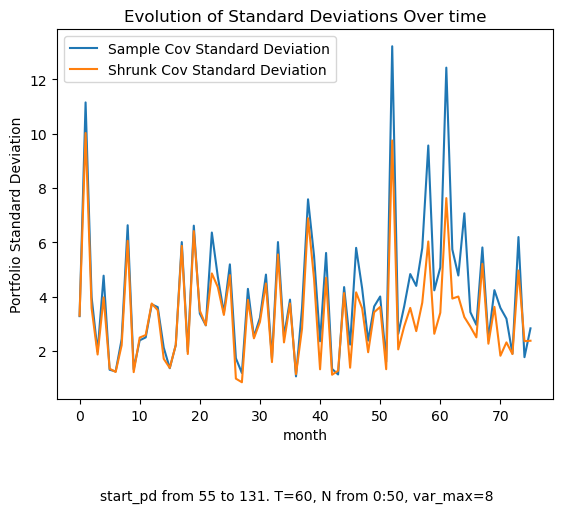

In [70]:
# plt.plot(np.arange(len(portfolio_returns)),portfolio_returns, label="Sample Cov Returns", linestyle='--')
plt.plot(np.arange(len(portfolio_returns)),np.sqrt(portfolio_variances), label="Sample Cov Standard Deviation")
# plt.plot(np.arange(len(portfolio_returns)),shrunk_portfolio_returns, label="Shrunk Cov Returns", linestyle=':')
plt.plot(np.arange(len(portfolio_returns)),np.sqrt(shrunk_portfolio_variances), label="Shrunk Cov Standard Deviation")
plt.xlabel("month")
plt.ylabel("Portfolio Standard Deviation")
plt.legend()
plt.title("Evolution of Standard Deviations Over time")
plt.figtext(0.5, -0.1, "start_pd from 55 to 131. T=60, N from 0:50, var_max=8", ha="center", fontsize=10)

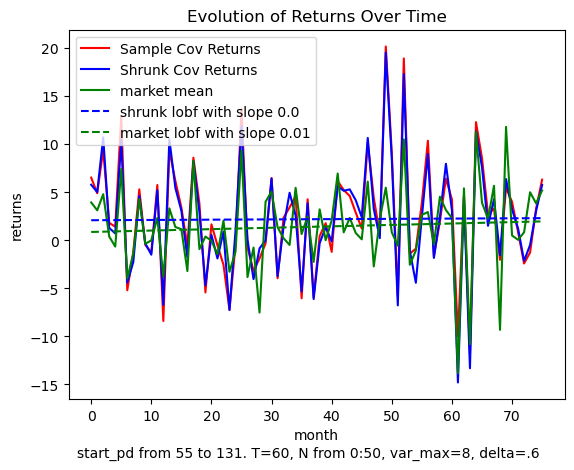

In [85]:
# plot the returns data
plt.plot(np.arange(len(portfolio_returns)),portfolio_returns, label="Sample Cov Returns", color='red')
plt.plot(np.arange(len(shrunk_portfolio_returns)),shrunk_portfolio_returns, label="Shrunk Cov Returns",color='blue')
plt.xlabel("month")
plt.ylabel("returns")
plt.title("Evolution of Returns Over Time")
plt.figtext(0.5, -0.01, "start_pd from 55 to 131. T=60, N from 0:50, var_max=8, delta=.6", ha="center", fontsize=10)

# construct and plot market average returns per time period
market_averages = []
market_variances = []
for i in range(55+T,131+T):
    market_averages.append(np.mean(returns.iloc[i,:]))
    market_variances.append(np.var(returns.iloc[i,:]))    
plt.plot(np.arange(0,76), market_averages, label = "market mean", color='green')


# add lines of best fit
# lobf for shrunk cov
x = np.arange(len(portfolio_returns))
y = shrunk_portfolio_returns
coefficients = np.polyfit(x, y, 1)  # 1 for linear regression
m, b = coefficients

plt.plot(x, m * x + b, color='blue', label = "shrunk lobf with slope " + str(round(m,2)), ls="--")


# lobf for market returns
x = np.arange(0,76)
y = market_averages
coefficients = np.polyfit(x, y, 1)  # 1 for linear regression
m, b = coefficients

plt.plot(x, m * x + b, color='green', label = "market lobf with slope " + str(round(m,2)), ls="--")


plt.legend()

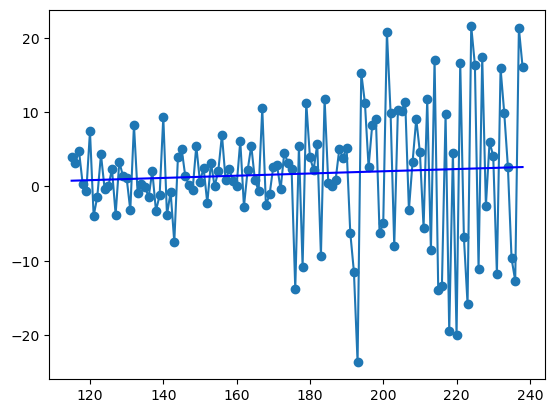

In [796]:
# create the market averages for plotting
market_averages = []
market_variances = []
for i in range(55+T,178+T+1):
    market_averages.append(np.mean(returns.iloc[i,:]))
    market_variances.append(np.var(returns.iloc[i,:]))    
plt.plot(np.arange(55+T,178+T+1), market_averages, label = "market mean")
# plt.plot(np.arange(55+T,178+T+1), np.sqrt(market_variances))
# plt.plot(np.arange(55+T,178+T), portfolio_returns, label="sample cov")

x = np.arange(55+T,178+T+1)
y = market_averages
coefficients = np.polyfit(x, y, 1)  # 1 for linear regression
m, b = coefficients

# Create the scatter plot
plt.scatter(x, y)

# Add the line of best fit
plt.plot(x, m * x + b, color='blue')

In [120]:
print("average market returns", np.mean(market_averages)) #sample
print("average market variance", np.mean(np.sqrt(market_variances)) /N )

print("variance decrease", np.mean(np.array(shrunk_portfolio_variances) - np.array(market_variances)/N))
print("returns improvement", np.mean(np.array(shrunk_portfolio_returns) - (market_averages)))

average market returns 1.4246935662470364
average market variance 0.3021030003182233
variance decrease 9.470766486871945
returns improvement 0.778644143002797


In [78]:
t_stat, p_value = ttest_rel(shrunk_portfolio_returns, market_averages)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 1.9433566876688932, P-value: 0.055725481501794676


In [88]:
# using variables stored from running with N:200-250
t_stat, p_value = ttest_rel(shrunk_portfolio_returns, market_averages)

print(f"T-statistic: {t_stat}, P-value: {p_value}")
# T-statistic: 1.7824732109439552, P-value: 0.07871908601928998

T-statistic: 1.7824732109439552, P-value: 0.07871908601928998
